In [26]:
import numpy as np
from numpy import pi, sqrt, cos, sin
import matplotlib.pyplot as plt

%matplotlib inline

The 1D Burgers with viscosity is

\begin{equation}
\frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2} - u \frac{\partial u}{\partial x}\,.
\end{equation}

Fourier transforming in the pseudo-spectral sprit, we obtain
\begin{equation}
\frac{d \hat{u}_k}{d t} = -\underbrace{\nu k^2 \hat{u}_k}_{Lin}- \underbrace{(\hat{u \partial_x u})_k}_{NL}\,.
\end{equation}

We solve this eqn. in a periodic domain of length $2\pi$ with initial condition:

\begin{equation}
u_0 = \sin(x)\,.
\end{equation}

In [3]:
N = 2048
L = 2.*pi
dx = L/N
nu = 1.e-3
dt = .2*dx
x = np.arange(0.,L,dx)
u0 = sin(x)
k = np.arange(0.,N/2+1)

In [4]:
Lin = -nu*dt*(k**2)  # the  viscous linear operator of 1D Burgers eqn.

def NL(k,uh,N):
    """ Compute dealiased nonlinear term of 1D Burgers eqn """
    
    uh_pad = np.zeros(3*N/4+1,dtype='complex128')
    uxh_pad = np.zeros(3*N/4+1,dtype='complex128')

    uh_pad[:N/2+1] = uh
    uxh_pad[:N/2+1] = 1j*k*uh

    u_pad = np.fft.irfft(uh_pad)
    ux_pad = np.fft.irfft(uxh_pad)           

    return -np.fft.rfft(u_pad*ux_pad)[:N/2+1]

In [13]:
def stepforward(k,uh,N,dt,Lin,NL):
    """ Step 1D Burgers equation forwards using a RK3W-theta scheme:
            implicit for linear viscous term and explicit for NL term """
    a1, a2, a3 = 29./96., -3./40., 1./6.
    b1, b2, b3 = 37./160., 5./24., 1./6.
    c1, c2, c3 = 8./15., 5./12., 3./4.
    d1, d2 = -17./60., 5./12.
    
    NL1 = NL(k,uh,N)
    uh = ( (1. + a1*Lin)/(1. - b1*Lin) )*uh + c1*dt*NL1
    
    NL2 = NL1.copy()
    NL1 = NL(k,uh,N)
    uh = ( (1. + a2*Lin)/(1. - b2*Lin) )*uh + c2*dt*NL1 + d1*dt*NL2

    NL2 = NL1.copy()
    NL1 = NL(k,uh,N)
    uh = ( (1. + a3*Lin)/(1. - b3*Lin) )*uh + c3*dt*NL1 + d2*dt*NL2

    return uh

In [6]:
tmax = 5.25
nmax = int(np.ceil(tmax/dt))

In [7]:
uh = np.fft.rfft(u0)
for i in range(nmax):
    uh = stepforward(k,uh,N,dt,Lin,NL)

In [8]:
u = np.fft.irfft(uh)

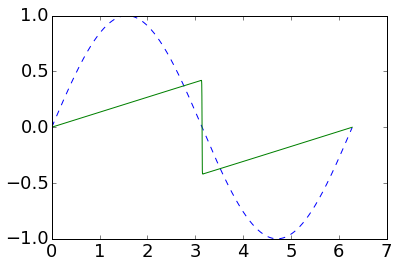

In [9]:
plt.plot(x,u0,'--')
plt.plot(x,u)

In [22]:
normu_python = 121.35437735625064  
normu_fortran = 121.35437735625098
normu = (u**2).sum()

In [23]:
np.testing.assert_allclose(normu,normu_python,rtol=1.e-15,atol=1.e-15)

In [24]:
np.testing.assert_allclose(normu,normu_fortran,rtol=1.e-15,atol=1.e-15)

AssertionError: 
Not equal to tolerance rtol=1e-15, atol=1e-15

(mismatch 100.0%)
 x: array(121.35437735625064)
 y: array(121.35437735625098)

In [25]:
normu_fortran-normu_python

3.410605131648481e-13

In [27]:
(normu_fortran-normu_python)/normu_python

2.8104508514235393e-15